# RBI LLM Fine-Tuning

This notebook contains the code for fine-tuning a language model on RBI (Reserve Bank of India) banking regulations and circulars. The model will be trained to answer questions related to Indian banking regulations.

## Setup and Imports

Importing necessary libraries and setting up environment variables.

In [ ]:
# !pip install transformers hf_transfer datasets peft matplotlib bitsandbytes accelerate tensorboard

In [ ]:
# !MAX_JOBS=4 pip install flash-attn --no-build-isolation

In [ ]:
# !pip install rouge-score

In [ ]:
# Expose 6006 for tensorboard

In [ ]:
import torch
import torch.nn as nn
from datasets import load_dataset,load_metric
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
import numpy as np
# from rich import print
# from dotenv import load_dotenv
# load_dotenv()

In [2]:
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"cuDNN Version: {torch.backends.cudnn.version()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Capability: {torch.cuda.get_device_capability(0)}")

PyTorch Version: 2.7.1+cu126
CUDA Available: True
CUDA Version: 12.6
cuDNN Version: 90501
GPU Name: NVIDIA L40
GPU Capability: (8, 9)


In [ ]:
PARA = 3
MODEL_NAME = f"Qwen/Qwen2.5-{PARA}B-Instruct"
MODEL_PATH = "./Models"
MODEL_OUTPUT_DIR = f"./Models/Qwen2.5-{PARA}B-Instruct-RBI-QA"
DATASET_NAME = "Vishva007/RBI-Circular-QA-Dataset"
MODEL_ADOPTOR_REPO_ID = f"Vishva007/Qwen2.5-{PARA}B-Instruct-RBI-QA-Adoptor"
SEED = 42# type: ignore

In [4]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [5]:
if not torch.cuda.is_available():
    print("CUDA not available, using CPU. This will be very slow.")
    device_map = "cpu"
else:
    device_map = "auto"
    print("GPU is Used!")

GPU is Used!


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, trust_remote_code=True,cache_dir=MODEL_PATH)
if not tokenizer.pad_token:
    print("Pad token is missing, setting it to EOS token.")
    tokenizer.pad_token = tokenizer.eos_token  # Set pad token if it's missing
tokenizer.padding_side = "left"  # IMPORTANT: Set padding_side to 'left' BEFORE tokenizing
print(tokenizer.pad_token)
print(tokenizer.eos_token)

Before : <|endoftext|>
After : <|endoftext|>


## Dataset Preparation

Loading and preparing the dataset containing RBI circulars and question-answer pairs.

In [7]:
dataset = load_dataset(DATASET_NAME, split="train") # type: ignore
print(f"Dataset loaded with {len(dataset)} samples.") # type: ignore
print(dataset)

Dataset loaded with 12698 samples.
Dataset({
    features: ['document', 'filename', 'model_name', 'regulation_area', 'applicable_to', 'issued_on', 'key_topics', 'chunks_text', 'is_table', 'question', 'answer', 'evaluation_criteria', 'category', 'estimated_difficulty', 'rephrased_question', 'rephrased_answer'],
    num_rows: 12698
})


In [8]:
sys_prompt = """
You are a highly knowledgeable AI assistant with expertise in Indian banking and financial regulations, 
particularly those outlined in Reserve Bank of India (RBI) circulars.
Your task is to answer questions based on the RBI circulars and related financial regulations.
"""

def format_data(sample):
    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": sample["question"]},
        {"role": "assistant", "content": sample["answer"]}
    ]
    # apply_chat_template will convert the list of messages into a single string
    # for the model input, adding control tokens like <s> and </s> if the model
    # supports them. `tokenize=False` ensures it returns a string, not token IDs.
    formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
    return {"text": formatted_prompt}

In [9]:
dataset = dataset.map(format_data).filter(lambda x: x is not None and x["text"] is not None)

In [10]:
print(dataset[5]['text'])

<|im_start|>system

You are a highly knowledgeable AI assistant with expertise in Indian banking and financial regulations, 
particularly those outlined in Reserve Bank of India (RBI) circulars.
Your task is to answer questions based on the RBI circulars and related financial regulations.
<|im_end|>
<|im_start|>user
What is the procedure for handling foreign investment reporting delays exceeding three years?<|im_end|>
<|im_start|>assistant
When forms are filed with a delay greater than three years regarding foreign investment reporting, the AD bank will approve the forms subject to compounding of contravention, after which the applicant may approach the RBI with their application for compounding.<|im_end|>



In [11]:
def tokenize_function(examples):
    # Tokenize the texts with padding and truncation
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)


In [12]:
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['document', 'filename', 'model_name', 'regulation_area', 'applicable_to', 'issued_on', 'key_topics',
'chunks_text', 'is_table', 'question', 'answer', 'evaluation_criteria', 'category', 'estimated_difficulty', 
'rephrased_question', 'rephrased_answer','text'],
)


In [13]:
# tokenized_dataset[0] # type: ignore

In [14]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

In [15]:
print(f"Formatted dataset with {len(dataset)} samples.")
print(dataset[0])
print(f"Train dataset size: {len(train_dataset)}")
print(f"Eval dataset size: {len(eval_dataset)}")

Formatted dataset with 12698 samples.
{'document': 'RBI_2022-2023_160A.P. (DIR Series) Circular No. 22_2023-01-04', 'filename': 'RBI_2022-2023_160A.P. (DIR Series) Circular No. 22_2023-01-04_text_part1.txt', 'model_name': 'models/gemini-2.0-flash', 'regulation_area': 'Foreign Investment in India', 'applicable_to': 'All Category-I Authorised Dealer Banks', 'issued_on': '2023-01-04', 'key_topics': ['Rationalisation of reporting in Single Master Form (SMF) on FIRMS Portal', 'Auto-acknowledgement of SMF in FIRMS', 'Online calculation of LSF', 'Late Submission Fee (LSF)'], 'chunks_text': '![](_page_0_Picture_0.jpeg)\n\n![](_page_0_Picture_1.jpeg)\n\n![](_page_0_Picture_2.jpeg)\n\nRBI/2022-23/160 A.P. (DIR Series) Circular No. 22 January 04, 2023\n\nTo All Category-I Authorised Dealer Banks\n\nMadam / Sir\n\n## **Foreign Investment in India - Rationalisation of reporting in Single Master Form (SMF) on FIRMS Portal**\n\nAttention of Authorised Dealer Category-I banks (AD banks) is invited to 

## Model Configuration

Configuring the model architecture and tokenizer for fine-tuning.

In [16]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [17]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype="auto",
    device_map="auto",
    trust_remote_code=True,
    attn_implementation="flash_attention_2",
    cache_dir=MODEL_PATH,
    quantization_config=quantization_config
)
print(model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-35): 36 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=True)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=True)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((2048,), 

## Training Configuration

Setting up the training parameters and callbacks for model fine-tuning.

In [18]:
# Assuming these are defined elsewhere in your context, similar to the image
CANDIDATE_ATTRS = ["model", "transformer", "decoder"]

def unwrap_to_base(model):
    for attr in CANDIDATE_ATTRS:
        if hasattr(model, attr):
            return getattr(model, attr)
    raise AttributeError(
        f"Could not find base model (e.g., model, transformer, decoder) "
        f"in {type(model).__name__}. Check CANDIDATE_ATTRS or inspect manually."
    )

def print_model_dimensions(model):
    """
    Prints the dimensions of individual Attention (q, k, v, o) and MLP (gate, up, down)
    layers based on the Qwen2 model structure.
    """
    base = unwrap_to_base(model)
    if not hasattr(base, 'layers') or not base.layers:
        raise ValueError("Model base does not have 'layers' attribute or layers are empty.")

    L0 = base.layers[0] # First decoder layer

    # --- ATTENTION ---
    print("ATTENTION")
    sa = L0.self_attn

    # Print individual q_proj, k_proj, v_proj, o_proj
    for name in ["q_proj", "k_proj", "v_proj", "o_proj"]:
        proj_module = getattr(sa, name, None)
        if isinstance(proj_module, nn.Linear):
            weight_shape = torch.Size([proj_module.out_features, proj_module.in_features]) # type: ignore
            print(f"{name:<10}: torch.Size({list(weight_shape)})")
        else:
            print(f"{name:<10}: Not a Linear module or missing.")


    # --- MLP ---
    print("\nMLP")
    mlp = L0.mlp

    # Print individual gate_proj, up_proj, down_proj
    for name in ["gate_proj", "up_proj", "down_proj"]:
        proj_module = getattr(mlp, name, None)
        if isinstance(proj_module, nn.Linear):
            weight_shape = torch.Size([proj_module.out_features, proj_module.in_features]) # type: ignore
            print(f"{name:<10}: torch.Size({list(weight_shape)})")
        else:
            print(f"{name:<10}: Not a Linear module or missing.")

In [19]:
print_model_dimensions(model)

ATTENTION
q_proj    : torch.Size([2048, 2048])
k_proj    : torch.Size([256, 2048])
v_proj    : torch.Size([256, 2048])
o_proj    : torch.Size([2048, 2048])

MLP
gate_proj : torch.Size([11008, 2048])
up_proj   : torch.Size([11008, 2048])
down_proj : torch.Size([2048, 11008])


In [20]:
model = prepare_model_for_kbit_training(model)

In [21]:
lora_config = LoraConfig(
    r=32,
    lora_alpha=24,
    use_rslora=True,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
)

In [22]:
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 59,867,136 || all params: 3,145,805,824 || trainable%: 1.9031


In [23]:
def create_data_collator_for_chat_training(tokenizer):
    """
    Creates a data collator that masks labels to -100 except for the assistant's response.
    This version properly handles chat formatting and finds assistant responses correctly.

    Args:
        tokenizer: The tokenizer used for encoding the data, expecting chat template support.

    Returns:
        A DataCollatorForLanguageModeling instance with custom label masking.
    """
    class CustomDataCollator(DataCollatorForLanguageModeling):
        def torch_call(self, features): # type: ignore
            # Pad inputs to the longest sequence in the batch
            batch = self.tokenizer.pad(
                features,
                return_tensors="pt",
                padding=True,
            )

            labels = batch["input_ids"].clone()

            # Get assistant prompt tokens consistently
            # Use return_attention_mask=False if you only need the input_ids
            # Ensure add_special_tokens=False to get only the tokens for the string part
            assistant_prompt_ids = self.tokenizer.encode(
                "<|im_start|>assistant\n", 
                add_special_tokens=False, 
                return_tensors="pt"
            )[0] # Get the first (and only) sequence

            # Get the im_end token ID
            im_end_token_id = self.tokenizer.convert_tokens_to_ids("<|im_end|>")
            
            # --- Debug prints within the collator ---
            # print(f"Collator: Assistant prompt IDs: {assistant_prompt_ids.tolist()}")
            # print(f"Collator: IM end token ID: {im_end_token_id}")
            # print(f"Collator: Tokenizer pad_token_id: {self.tokenizer.pad_token_id}")
            # print(f"Collator: Tokenizer eos_token_id: {self.tokenizer.eos_token_id}")
            # print(f"Collator: Is pad_token_id == im_end_token_id? {self.tokenizer.pad_token_id == im_end_token_id}")

            # Process each sequence in the batch
            for i, input_ids_tensor in enumerate(batch["input_ids"]):
                # Initialize all labels to -100 (ignore by default)
                labels[i, :] = -100

                # Find actual content start (first non-padding token)
                attention_mask = batch["attention_mask"][i]
                if attention_mask.sum() == 0:
                    continue
                    
                actual_start = (attention_mask == 1).nonzero(as_tuple=True)[0][0].item()
                actual_end = actual_start + attention_mask.sum().item()

                # Using torch operations for efficiency
                input_ids_torch = input_ids_tensor 
                
                # Find all assistant response sections
                assistant_starts = []
                assistant_ends = []
                
                len_prompt = assistant_prompt_ids.numel() # Use numel for torch tensor length
                
                for j in range(actual_start, actual_end - len_prompt + 1):
                    if torch.equal(input_ids_torch[j : j + len_prompt], assistant_prompt_ids.to(input_ids_torch.device)):
                        assistant_start = j + len_prompt
                        assistant_starts.append(assistant_start)
                        
                        # Find the corresponding end
                        assistant_end = None
                        im_end_indices = (input_ids_torch[assistant_start:actual_end] == im_end_token_id).nonzero(as_tuple=True)[0]
                        
                        if im_end_indices.numel() > 0:
                            assistant_end = assistant_start + im_end_indices[0].item() + 1 # +1 to include im_end token
                        else:
                            assistant_end = actual_end # If no end token found, go to end of actual content
                        
                        assistant_ends.append(assistant_end)

                # Unmask assistant responses
                for start, end in zip(assistant_starts, assistant_ends):
                    if start < end:
                        labels[i, start:end] = input_ids_tensor[start:end]
                        # print(f"Unmasked assistant response from {start} to {end}")

                # Debug: Print some info about what we found
                # print(f"Sequence {i}: Found {len(assistant_starts)} assistant responses")
                # if len(assistant_starts) > 0:
                #     print(f"  First assistant response starts at: {assistant_starts[0]}")
                #     decode_end = min(assistant_starts[0]+20, actual_end)
                #     print(f"  Content snippet: {self.tokenizer.decode(input_ids_tensor[assistant_starts[0]:decode_end], skip_special_tokens=False)}")

            batch["labels"] = labels
            return batch

    return CustomDataCollator(tokenizer=tokenizer, mlm=False)

In [24]:
data_collator = create_data_collator_for_chat_training(tokenizer)


In [ ]:
# sample_to_check = eval_dataset[0]
# print(f"Original tokenized sample (eval_dataset[0]): {sample_to_check}")

# # Manually call the data collator with this single sample (wrapped in a list for batching)
# collated_sample = data_collator([sample_to_check])


You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Original tokenized sample (eval_dataset[0]): {'input_ids': [151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 1516

In [ ]:

# print("\n--- Debugging Collated Sample ---")
# print("Input IDs:", collated_sample["input_ids"])
# print("Labels:", collated_sample["labels"])

# # Decode the labels to visually check masking
# decoded_labels = collated_sample["labels"][0].clone()
# decoded_labels[decoded_labels == -100] = tokenizer.pad_token_id # Replace -100 for decoding
# print("Decoded Labels (with masked parts as pad token):", tokenizer.decode(decoded_labels, skip_special_tokens=False))

# # Also, let's decode the original input_ids to compare
# print("Decoded Input IDs:", tokenizer.decode(collated_sample["input_ids"][0], skip_special_tokens=False))



--- Debugging Collated Sample ---
Input IDs: tensor([[151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151643, 151643, 151643, 151643, 151643, 151643

In [27]:
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_DIR,
    num_train_epochs=4, 
    per_device_train_batch_size=32,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=32, 
    eval_accumulation_steps=1,
    # max_steps=200,
    learning_rate=1e-4, 
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    fp16=True,
    eval_strategy="steps",
    eval_steps=100,  
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    push_to_hub=False,
    remove_unused_columns=False,
    logging_dir="./logs",
    logging_steps=50,
    report_to="tensorboard",
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    dataloader_pin_memory=False,  # Disable pin memory to save GPU memory
    dataloader_num_workers=0,     # Use single worker to save memory
    max_grad_norm=1.0,           # Add gradient clipping
    group_by_length=False,       # Disable to save memory
    length_column_name=None, 
)

### Tensorboard 

pip install tensorboard

cd ../workspace

tensorboard --logdir ./logs --host 0.0.0.0 --port 6006 --reload_interval 5

https://[pod_id]-6006.proxy.runpod.net/

In [ ]:

# 7. Initialize the Trainer
trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=training_args,
    data_collator=data_collator,
    # compute_metrics=partial(compute_metrics, tokenizer=tokenizer),  
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)]
)


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [29]:
train_result = trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.float16.


Step,Training Loss,Validation Loss
100,1.599700,1.499963
200,1.327100,1.250832
300,1.158200,1.090101
400,0.852800,0.992320
500,0.735100,0.896981
600,0.726800,0.831052
700,0.688500,0.790230
800,0.401100,0.818526
900,0.375900,0.782265


config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

In [30]:
model.save_pretrained(MODEL_OUTPUT_DIR) # type: ignore

## Model Evaluation

Evaluating the fine-tuned model's performance.

In [31]:
train_history = train_result.metrics
eval_history = trainer.evaluate()

In [32]:
final_eval_loss = eval_history.get("eval_loss")

if final_eval_loss is not None:
    final_perplexity = torch.exp(torch.tensor(final_eval_loss)).item()
    print(f"Final Evaluation Loss: {final_eval_loss:.4f}")
    print(f"Final Perplexity: {final_perplexity:.2f}")


Final Evaluation Loss: 0.7823
Final Perplexity: 2.19


Loss plot saved to ./loss_plot.png


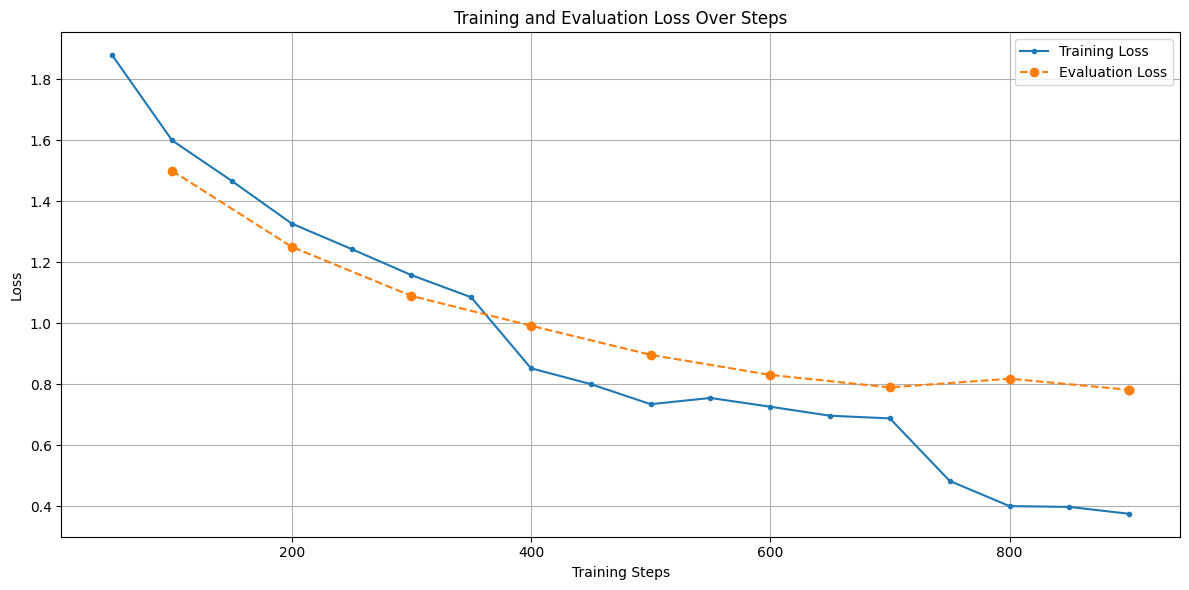

In [33]:
# --- 11. Extracting Metrics from log_history for Plotting ---
train_losses = []
eval_losses = []
eval_steps = [] # Store steps where evaluation occurred

# Iterate through the trainer's log_history
for log in trainer.state.log_history:
    # Training loss is logged at 'logging_steps' intervals
    if "loss" in log and "learning_rate" in log: # Check if it's a training step log
        train_losses.append({"step": log["step"], "loss": log["loss"]})
    # Evaluation loss is logged at 'eval_steps' intervals
    if "eval_loss" in log:
        eval_losses.append({"step": log["step"], "loss": log["eval_loss"]})

# Prepare data for plotting
train_steps_plot = [entry["step"] for entry in train_losses]
train_values_plot = [entry["loss"] for entry in train_losses]

eval_steps_plot = [entry["step"] for entry in eval_losses]
eval_values_plot = [entry["loss"] for entry in eval_losses]

# --- 12. Plotting the Training and Evaluation Loss ---
plt.figure(figsize=(12, 6))
plt.plot(train_steps_plot, train_values_plot, label="Training Loss", marker='.')
plt.plot(eval_steps_plot, eval_values_plot, label="Evaluation Loss", marker='o', linestyle='--')

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss Over Steps")
plt.legend()
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plot_path = os.path.join("./", "loss_plot.png")
plt.savefig(plot_path)
print(f"Loss plot saved to {plot_path}")
plt.show()

In [34]:
from huggingface_hub import notebook_login

notebook_login()

In [36]:

model.push_to_hub(MODEL_ADOPTOR_REPO_ID)  # type: ignore

tokenizer.push_to_hub(MODEL_ADOPTOR_REPO_ID)

print(f"LoRA adapters pushed to https://huggingface.co/{MODEL_ADOPTOR_REPO_ID}")

README.md: 0.00B [00:00, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/240M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


LoRA adapters pushed to https://huggingface.co/Vishva007/Qwen2.5-3B-Instruct-RBI-QA-Adoptor
